# Variational Quantum Eigensolver for Fermions: tutorial

In this notebook, we want to find a good approximation of the minimum energy ($E_0$) of a fermionic Hamiltonian $H$ of the form :
$$ H=\sum_{pq}h_{pq}c_p^\dagger c_q + \frac{1}{2} \sum_{pqrs} h_{pqrs}c_p^\dagger c_q^\dagger c_r c_s $$

To find this minimum, we invoke the Rayleigh-Ritz variational principle that stipulates that:
$$ \frac{\langle\Psi|H|\Psi\rangle}{\langle\Psi|\Psi\rangle} \geq E_0 \; \; \forall \Psi$$

The idea is to construct a family of variational wavefunctions $|\Psi(\vec{\theta})\rangle$ and find the parameter $\vec{\theta}^*$ that minimizes $\frac{\langle\Psi(\vec{\theta})|H|\Psi(\vec{\theta})\rangle}{\langle\Psi(\vec{\theta})|\Psi(\vec{\theta})\rangle} $.  

To construct such states, we use a quantum circuit that generates $\Psi(\vec{\theta})$ given a list of parameters $\vec{\theta}$. We then measure the mean value of $H$, $E(\vec{\theta})$, which we feed to a classical optimizer that will find a new set of parameters, and so on until a desired accuracy is achieved.

## Defining the Hamiltonian

Here, we define the fermionic Hamiltonian. For simplicity, we will focus on a very simple example: a **single-site Hubbard model**, defined by the Hamiltonian:
$$ H = U n_\uparrow n_\downarrow - \mu \sum_{\sigma=\uparrow,\downarrow} n_\sigma $$

with $n_\sigma \equiv c_\sigma^\dagger c_\sigma$.

Such a Hamiltonian is already part of the QLM's ``qat.fermion`` module via the ``make_hubbard_model`` function below. This function creates the hopping and interaction integrals $h_{pq}$ and $h_{pqrs}$ that define our Hamiltonian. 



In [1]:
import numpy as np

from qat.fermion.hamiltonians import make_hubbard_model

U = 2.0
nqbit = 2
t_mat = np.zeros((1, 1))
hamiltonian = make_hubbard_model(t_mat, U, mu=U / 2)

print("H = ", hamiltonian)

H =  -1.0 * (Cc|[0, 0]) +
-1.0 * (Cc|[1, 1]) +
-1.0 * (CCcc|[0, 1, 0, 1]) +
-1.0 * (CCcc|[1, 0, 1, 0])


The first step is to transform this fermionic Hamiltonian to a Hamiltonian that acts on qubits, i.e two-level systems. This transformation is not unique. Common transformations are the Jordan-Wigner and the Bravyi-Kitaev transformation. In the following cell, we use the Jordan-Wigner transform:

In [2]:
hamiltonian_spin = hamiltonian.to_spin()
print("H (spin) = ", hamiltonian_spin)

H (spin) =  (-0.5+0j) * I^2 +
(0.5+0j) * (ZZ|[0, 1])


### Ansatz and corresponding quantum circuit

The second step is to find a circuit with some parameters to generate our variational wavefunction $\Psi(\vec\theta)$. This ansatz has to be powerful enough to be able to come close enough to the ground state, but with as few as possible gates (to reduce the circuit depth) and parameters (to ease the task of the classical optimizer).

In our example, we take a list with only two parameters and we create a function that returns a ``QRoutine``. 

Note that we insert a CNOT because we know that our Hamiltonian contains terms entangling two orbitals in our fermionic system.

We encapsulate the QRoutine inside a Program that is itself converted into a parametric circuit:

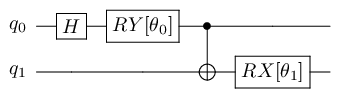

In [3]:
from qat.lang.AQASM import H, RX, RY, CNOT, QRoutine, Program


def simple_circuit_with_two_parameters(theta):
    """Take a parameter theta and return the corresponding circuit"""
    Qrout = QRoutine()
    Qrout.apply(H, 0)
    Qrout.apply(RY(theta[0]), 0)
    Qrout.apply(CNOT, 0, 1)
    Qrout.apply(RX(theta[1]), 1)
    return Qrout


prog = Program()
reg = prog.qalloc(hamiltonian_spin.nbqbits)
prog.apply(
    simple_circuit_with_two_parameters([prog.new_var(float, "\\theta_%s" % i) for i in range(hamiltonian_spin.nbqbits)]),
    reg,
)
circ = prog.to_circ()

%qatdisplay circ

## Job preparation

What we now want to achieve is the minimization of the expectation value $\langle \Psi(\vec{\theta})| H |\Psi(\vec{\theta})\rangle$ of the Hamiltonian $H$ at hand on the variational wavefunction $|\Psi(\vec{\theta})\rangle$ over the two-dimensional space of variational parameters $\vec{\theta}$. 
Such a computational job is described by a ``Job`` object that essentially contains information about

- the variational circuit: ``circ`` below
- the observable (Hamiltonian) to be minimized: ``hamilt_spin``

The ``nbshots`` variable indicates the number of repetitions of the state preparation and measurement that are devoted to the computation of the expectation value

In [4]:
job = circ.to_job(job_type="OBS", observable=hamiltonian_spin, nbshots=0)
theta0 = [0.5, 1.23]

This job is a parametric job because the parameters $\vec{\theta}$ of the circuit are not fixed. To handle such jobs, the QLM supplies special plugins whose purpose is to minimize the value of a job's observable over the job's parametric circuit.
The minimization can be carried out using various classical optimizers.

In the cell below, we use Scipy's Nelder-Mead optimizer as a backend for this minimization. The corresponding dedicated QLM Plugin is ``ScipyMinimizePlugin``:

In [5]:
from qat.plugins import ScipyMinimizePlugin
from qat.qpus import get_default_qpu

optimizer_scipy = ScipyMinimizePlugin(method="Nelder-Mead", x0=theta0, tol=1e-3, options={"maxiter": 600})
linalg_qpu = get_default_qpu()
qpu = optimizer_scipy | linalg_qpu
result = qpu.submit(job)

print("Minimum VQE energy =", result.value)

Minimum VQE energy = -0.9999999999915516


The ``result`` variable contains additional information about the variational procedure, such as the successive values of the variational energy over the course of the optimization, or the value of the optimal parameters $\vec{\theta}^*$:

Theta* =  [-0.1168944245437169, 3.1415984667744556]


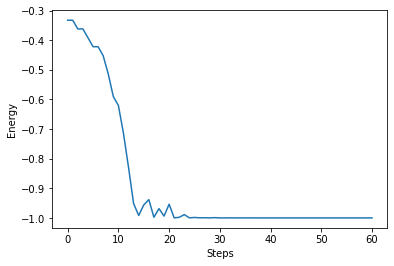

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(eval(result.meta_data["optimization_trace"]))
plt.xlabel("Steps")
plt.ylabel("Energy")

print("Theta* = ", result.meta_data["parameters"])

### Simultaneous Perturbation Stochastic Approximation optimizer

We now switch to another classical optimizer, SPSA:

Minimum energy = -0.9991606579426189


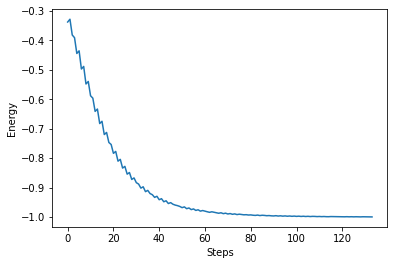

In [7]:
from qat.plugins import SPSAMinimizePlugin

optimizer_spsa = SPSAMinimizePlugin(theta0)

qpu = optimizer_spsa | linalg_qpu
result = qpu.submit(job)

print("Minimum energy =", result.value)
plt.plot(eval(result.meta_data["optimization_trace"]))
plt.xlabel("Steps")
plt.ylabel("Energy");

 ### Particle-Swarm Optimizer

Similarly, we can use a Particle-Swarm Optimizer, PSO. We can specify the number of swarm particles used for the optimization. In the following example, we take 10.

Minimum energy = -1.0


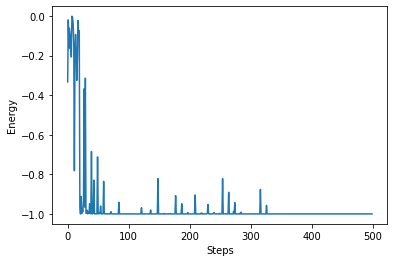

In [8]:
from qat.plugins import PSOMinimizePlugin

optimizer_pso = PSOMinimizePlugin(theta0, max_iter=50, swarm_number=10)
qpu = optimizer_pso | linalg_qpu
result = qpu.submit(job)

print("Minimum energy =", result.value)

plt.plot(eval(result.meta_data["optimization_trace"]))
plt.xlabel("Steps")
plt.ylabel("Energy");

 ### Gradient Descent optimizer with or without the use of natural gradients

Finally, we can use the `GradientDescentOptimizer` to optimize the parameters

#### Gradient descent without and with natural gradients

Energy obtained via gradient descent = -0.9998732328518045
Energy obtained via natural gradient descent = -0.9995722604846401


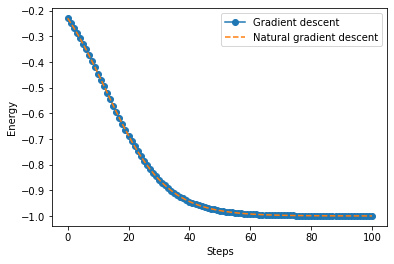

In [9]:
from qat.plugins import GradientDescentOptimizer

gradient_descent = GradientDescentOptimizer(maxiter=100, lambda_step=0.1, natural_gradient=False, tol=1e-7)
natural_gradient = GradientDescentOptimizer(maxiter=100, lambda_step=0.1, natural_gradient=True, tol=1e-7)

qpu_grad = gradient_descent | linalg_qpu
qpu_natgrad = natural_gradient | linalg_qpu

result_grad = qpu_grad.submit(job)
result_natgrad = qpu_natgrad.submit(job)

plt.plot(eval(result_grad.meta_data["optimization_trace"]), "-o", label="Gradient descent")
plt.plot(eval(result_grad.meta_data["optimization_trace"]), "--", label="Natural gradient descent")
plt.xlabel("Steps")
plt.ylabel("Energy")
plt.legend()

print(f"Energy obtained via gradient descent = {result_grad.value}")
print(f"Energy obtained via natural gradient descent = {result_natgrad.value}")

### Exact result
It may be interesting to compare this result with an exact result. This can be done, in this simple case, by a full exact diagonalisation:

In [10]:
eigvals, eigvecs = np.linalg.eigh(hamiltonian_spin.get_matrix())
print("Exact ground-state energy =", min(eigvals))

Exact ground-state energy = -1.0
